# Importing the Libraries

In [53]:
# PySpark Core
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, when, isnan, lit, mean, sum as pysum, count, regexp_replace
from pyspark.sql.types import DoubleType

# PySpark ML
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Numerik & DataFrame Pandas
import numpy as np
import pandas as pd

# Sklearn metrics
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, 
    f1_score, recall_score, precision_score
)

# Load Dataset
#### Data: https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset


In [57]:
# Inisialisasi Spark Session
spark = SparkSession.builder.appName("BigDataProject").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Load Data
df = spark.read.csv("*.csv", header=True, inferSchema=True)

# Membuat kolom BinaryLabel
df = df.withColumn(
    "BinaryLabel",
    when(col(" Label") == "BENIGN", "Normal").otherwise("Attack")
)

print("\n=== TOTAL GABUNGAN ===")
print(f"{df.count():,} baris")
print(f"Jumlah Kolom: {len(df.columns)}")

print("\n=== Distribusi Binary Label ===")
df.groupBy("BinaryLabel").count().show()


=== TOTAL GABUNGAN ===
2,830,743 baris
Jumlah Kolom: 80

=== Distribusi Binary Label ===


[Stage 195:=================>                                      (4 + 9) / 13]

+-----------+-------+
|BinaryLabel|  count|
+-----------+-------+
|     Attack| 557646|
|     Normal|2273097|
+-----------+-------+



# Data Cleaning

In [48]:
# konversi data ke pandas untuk visualisasi
pdf = df.limit(5).toPandas()
pdf

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,BinaryLabel
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Normal
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Normal
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Normal
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Normal
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Normal


In [49]:
df.printSchema()

root
 |--  Destination Port: integer (nullable = true)
 |--  Flow Duration: integer (nullable = true)
 |--  Total Fwd Packets: integer (nullable = true)
 |--  Total Backward Packets: integer (nullable = true)
 |-- Total Length of Fwd Packets: integer (nullable = true)
 |--  Total Length of Bwd Packets: integer (nullable = true)
 |--  Fwd Packet Length Max: integer (nullable = true)
 |--  Fwd Packet Length Min: integer (nullable = true)
 |--  Fwd Packet Length Mean: double (nullable = true)
 |--  Fwd Packet Length Std: double (nullable = true)
 |-- Bwd Packet Length Max: integer (nullable = true)
 |--  Bwd Packet Length Min: integer (nullable = true)
 |--  Bwd Packet Length Mean: double (nullable = true)
 |--  Bwd Packet Length Std: double (nullable = true)
 |-- Flow Bytes/s: double (nullable = true)
 |--  Flow Packets/s: double (nullable = true)
 |--  Flow IAT Mean: double (nullable = true)
 |--  Flow IAT Std: double (nullable = true)
 |--  Flow IAT Max: integer (nullable = true)
 |-- 

In [58]:
#Menghapus spasi di awal dan akhir nama kolom
for column_name in df.columns:
    df = df.withColumnRenamed(column_name, column_name.strip())


In [51]:
df.printSchema()

root
 |-- Destination Port: integer (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Total Fwd Packets: integer (nullable = true)
 |-- Total Backward Packets: integer (nullable = true)
 |-- Total Length of Fwd Packets: integer (nullable = true)
 |-- Total Length of Bwd Packets: integer (nullable = true)
 |-- Fwd Packet Length Max: integer (nullable = true)
 |-- Fwd Packet Length Min: integer (nullable = true)
 |-- Fwd Packet Length Mean: double (nullable = true)
 |-- Fwd Packet Length Std: double (nullable = true)
 |-- Bwd Packet Length Max: integer (nullable = true)
 |-- Bwd Packet Length Min: integer (nullable = true)
 |-- Bwd Packet Length Mean: double (nullable = true)
 |-- Bwd Packet Length Std: double (nullable = true)
 |-- Flow Bytes/s: double (nullable = true)
 |-- Flow Packets/s: double (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: integer (nullable = true)
 |-- Flow IAT Min: in

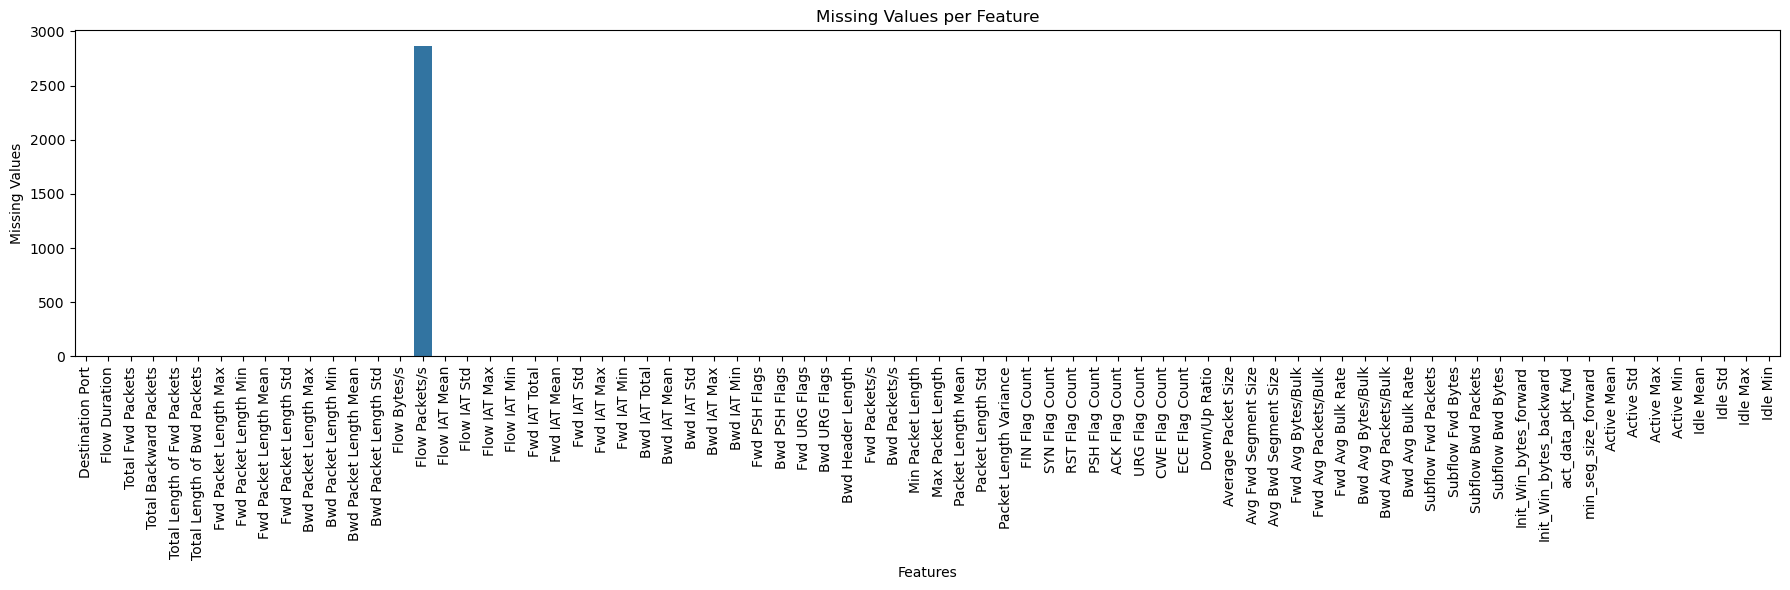

In [65]:
# Hitung missing values per kolom
missing_values = df.select([
    count(when(
        col(c).isNull() |                     
        isnan(col(c)) |                       
        (col(c) == "") |                      
        (col(c) == float("inf")) |            
        (col(c) == float("-inf")) ,                        
        c
    )).alias(c)
    for c in df.columns
    if dict(df.dtypes)[c] in ['int', 'double', 'float', 'long']
]).toPandas().T


#visualisasi mising value
def plotMissingValues(missing_values):
    plt.figure(figsize=(18, 6))
    sns.barplot(
        x=missing_values.index,
        y=missing_values[0]
    )
    plt.xticks(rotation=90)
    plt.xlabel("Features")       
    plt.ylabel("Missing Values")   
    plt.title("Missing Values per Feature")
    plt.tight_layout()
    plt.show()


plotMissingValues(missing_values)


In [68]:
from pyspark.sql.functions import col, isnan

cond_bytes = (
    isnan(col("Flow Bytes/s")) | 
    col("Flow Bytes/s").isNull() | 
    (col("Flow Bytes/s") == float("inf"))|
    (col("Flow Packets/s") == float("-inf"))
)

cond_packets = (
    isnan(col("Flow Packets/s")) | 
    col("Flow Packets/s").isNull() | 
    (col("Flow Packets/s") == float("inf"))|
    (col("Flow Packets/s") == float("-inf"))
)

num_missing = df.filter(cond_bytes | cond_packets)

print(f"Jumlah baris bermasalah (di Flow Bytes/s ATAU Flow Packets/s): {num_missing.count()}")

print("\n=== Detail Label yang Bermasalah ===")
num_missing.select("Label", "BinaryLabel").groupBy("Label").count().show()

Jumlah baris bermasalah (di Flow Bytes/s ATAU Flow Packets/s): 2867

=== Detail Label yang Bermasalah ===


[Stage 225:==================================================>    (12 + 1) / 13]

+-----------+-----+
|      Label|count|
+-----------+-----+
|     BENIGN| 1777|
|       DDoS|    2|
|   PortScan|  126|
|FTP-Patator|    3|
|   DoS Hulk|  949|
|        Bot|   10|
+-----------+-----+



In [69]:
# Melakukan Imputasi
target_columns = ["Flow Bytes/s", "Flow Packets/s"]

def impute_column(df, column_name):
    print(f"\nProcessing Column: {column_name}...")

    # Pastikan tipe double
    df = df.withColumn(column_name, col(column_name).cast("double"))

    # Hitung mean dari data bersih
    stats = df.filter(
        col(column_name).isNotNull() & 
        ~isnan(col(column_name)) & 
        (col(column_name) != float('inf')) & 
        (col(column_name) != float('-inf'))
    ).agg(mean(column_name).alias("avg_val")).collect()

    mean_val = stats[0]["avg_val"] or 0.0
    print(f" -> Mean digunakan: {mean_val}")

    # Imputasi NaN, Null, Inf, -Inf
    df = df.withColumn(
        column_name,
        when(
            col(column_name).isNull() | 
            isnan(col(column_name)) | 
            (col(column_name) == float('inf')) | 
            (col(column_name) == float('-inf')),
            lit(mean_val)
        ).otherwise(col(column_name))
    )

    # Verifikasi sisa error
    remaining = df.filter(
        col(column_name).isNull() | 
        isnan(col(column_name)) | 
        (col(column_name) == float('inf')) | 
        (col(column_name) == float('-inf'))
    ).count()

    print(f" -> Sisa Error (NaN/Inf/Null) di {column_name}: {remaining}")
    return df

print("--- Memulai Imputasi untuk Flow Bytes & Flow Packets ---")
for c in target_columns:
    df = impute_column(df, c)

--- Memulai Imputasi untuk Flow Bytes & Flow Packets ---

Processing Column: Flow Bytes/s...


 -> Mean digunakan: 1491719.0643420392


 -> Sisa Error (NaN/Inf/Null) di Flow Bytes/s: 0

Processing Column: Flow Packets/s...


 -> Mean digunakan: 70854.23306263573


[Stage 237:=========================>                              (6 + 7) / 13]

 -> Sisa Error (NaN/Inf/Null) di Flow Packets/s: 0


In [73]:
from pyspark.sql.functions import col

print("--- Memeriksa Kolom Zero Variance ---")

total_rows = df.count()
columns_to_drop = []

for c in df.columns:
    dtype = dict(df.dtypes)[c]
    if dtype in ['int', 'double', 'float', 'long', 'bigint']:
        zero_count = df.filter(col(c) == 0).count()
        if zero_count == total_rows:
            print(f"Menandai kolom untuk dihapus: {c}")
            columns_to_drop.append(c)

if columns_to_drop:
    df = df.drop(*columns_to_drop)
    print(f"Berhasil menghapus {len(columns_to_drop)} kolom.")
else:
    print("Tidak ada kolom yang 100% nol.")

print(f"Jumlah kolom sekarang: {len(df.columns)}")


--- Memeriksa Kolom Zero Variance ---


Menandai kolom untuk dihapus: Bwd PSH Flags


Menandai kolom untuk dihapus: Bwd URG Flags


Menandai kolom untuk dihapus: Fwd Avg Bytes/Bulk


Menandai kolom untuk dihapus: Fwd Avg Packets/Bulk


Menandai kolom untuk dihapus: Fwd Avg Bulk Rate


Menandai kolom untuk dihapus: Bwd Avg Bytes/Bulk


Menandai kolom untuk dihapus: Bwd Avg Packets/Bulk


Menandai kolom untuk dihapus: Bwd Avg Bulk Rate


[Stage 481:==============================================>        (11 + 2) / 13]

Berhasil menghapus 8 kolom.
Jumlah kolom sekarang: 72


In [77]:
# Daftar kolom yang akan dihapus jika ada
for c in ["Fwd Header Length55", "Label"]:
    if c in df.columns:
        df = df.drop(c)

print(f"Total kolom tersisa: {len(df.columns)}")


Total kolom tersisa: 70


# Data Preprocessing

In [15]:
# Mengubah BinaryLabel menjadi numerik 0 dan 1
df = df.withColumn(
    "BinaryLabel",
    when(col("BinaryLabel") == "Normal", 0)
    .when(col("BinaryLabel") == "Attack", 1)
)

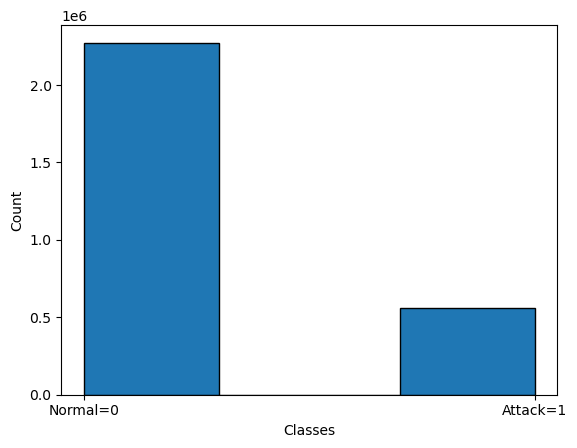

In [16]:
binary_label_pd = df.select("BinaryLabel").toPandas()["BinaryLabel"]

# Plot histogram
plt.hist(binary_label_pd, bins=[0, 0.3, 0.7, 1], edgecolor='black')
plt.xticks([0, 1], labels=['Normal=0', 'Attack=1'])
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

In [17]:
# Resample
# Pisahkan kelas mayoritas dan minoritas
df_majority = df.filter(col("BinaryLabel") == 0)
df_minority = df.filter(col("BinaryLabel") == 1)

# Hitung jumlah baris minoritas
n_minority = df_minority.count()
n_majority = df_majority.count()

# Hitung proporsi untuk sample mayoritas agar seimbang
fraction = n_minority / n_majority

# Lakukan undersampling pada mayoritas
df_majority_undersampled = df_majority.sample(withReplacement=False, fraction=fraction, seed=42)

# Gabungkan dengan minoritas
df_balanced = df_majority_undersampled.union(df_minority)

# Verifikasi distribusi
df_balanced.groupBy("BinaryLabel").count().show()
print(f"Total Baris Baru: {df_balanced.count():,}")



=== Distribusi Kelas Setelah Undersampling ===
BinaryLabel
0    557646
1    557646
Name: count, dtype: int64
Total Baris Baru: 1,115,292 (sekitar 1.11 juta)


In [18]:
# PEMILIHAN FEATURE
# Gunakan df_balanced sebagai dataset
df = df_balanced

# Tentukan target
target_column = "BinaryLabel"

# Fitur (semua kolom kecuali target)
feature_columns = [c for c in df.columns if c != target_column]

X = df.select(*feature_columns)  # DataFrame fitur
Y = df.select(target_column)     # DataFrame target


In [19]:
# Standardization
# Kolom yang tidak diskalakan
cols_no_scale = [
    'Destination Port', 
    'Fwd PSH Flags', 'Fwd URG Flags', 
    'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 
    'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count'
]

# Pilih kolom numerik untuk scaling, kecuali yang tidak diskalakan
numeric_cols = [f.name for f in X.schema.fields if str(f.dataType) in ['IntegerType','DoubleType','LongType']]
numeric_cols_to_scale = [c for c in numeric_cols if c not in cols_no_scale]

# Gabungkan kolom yang diskalakan menjadi satu vector
assembler = VectorAssembler(inputCols=numeric_cols_to_scale, outputCol="features_vector")
X_vec = assembler.transform(X)

# StandardScaler
scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(X_vec)
X_scaled = scaler_model.transform(X_vec)

# Jika mau lihat hasil scaling (misal Flow Duration)
X_scaled.select("scaled_features").show(5, truncate=False)


Contoh nilai Flow Duration (setelah Scaling):
 1379160   -0.536475
2754507   -0.536475
1504770   -0.403804
1529545   -0.533040
827466    -0.536475
Name: Flow Duration, dtype: float64


In [20]:
# DATA SPLITTING
# Gabungkan fitur dan target menjadi satu DataFrame
data = X.join(Y)

# Split data (70% train, 30% test)
train_df, test_df = data.randomSplit([0.7, 0.3], seed=42)

print(f"Jumlah Total Data Latih (Train): {train_df.count():,}")
print(f"Jumlah Total Data Uji (Test): {test_df.count():,}")


DATA SPLITTING (70% Train, 20% Test)
Jumlah Total Data Latih (Train): 780,704
Jumlah Total Data Uji (Test): 334,588


# Modeling

## Random Forest

In [21]:
feature_columns = X.columns 
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Inisialisasi Random Forest
rf = RandomForestClassifier(
    featuresCol="features", 
    labelCol="BinaryLabel", 
    numTrees=50, 
    seed=42
)

# Buat pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Latih model
rf_model = pipeline.fit(train_df)

# Prediksi
rf_pred = rf_model.transform(test_df)

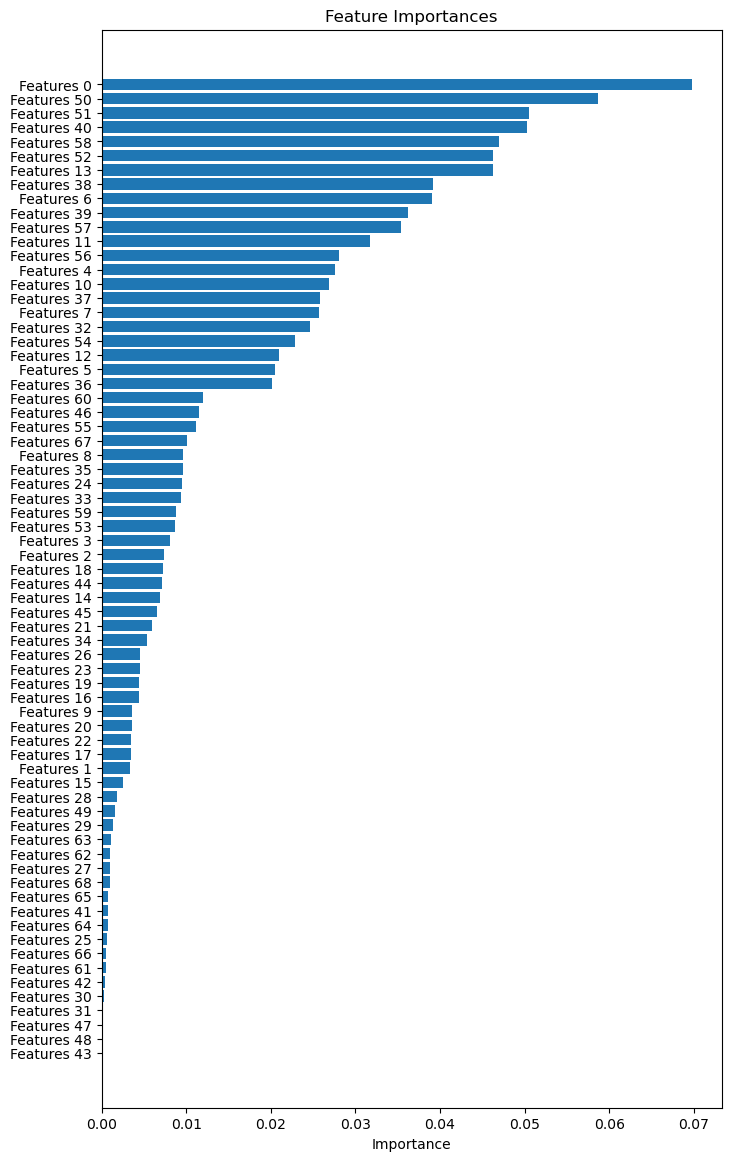

In [22]:
rf_stage = rf_model.stages[-1] 

# Ambil feature importances
importances = rf_stage.featureImportances.toArray()

# Buat nama fitur dari VectorAssembler
feature_names = assembler.getInputCols()

# Urutkan descending
indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=False)

plt.figure(figsize=(8, len(feature_names)*0.3))
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

### Model Evaluation


Random Forest Metrics:
Accuracy (Akurasi Total): 0.9991
F1 Score (Keseimbangan): 0.9991
Precision (Ketepatan Prediksi Attack): 0.9988
Recall (Sensitivitas Deteksi Attack): 0.9993

Laporan Klasifikasi Lengkap:
               precision    recall  f1-score   support

           0     0.9993    0.9988    0.9991    167294
           1     0.9988    0.9993    0.9991    167294

    accuracy                         0.9991    334588
   macro avg     0.9991    0.9991    0.9991    334588
weighted avg     0.9991    0.9991    0.9991    334588



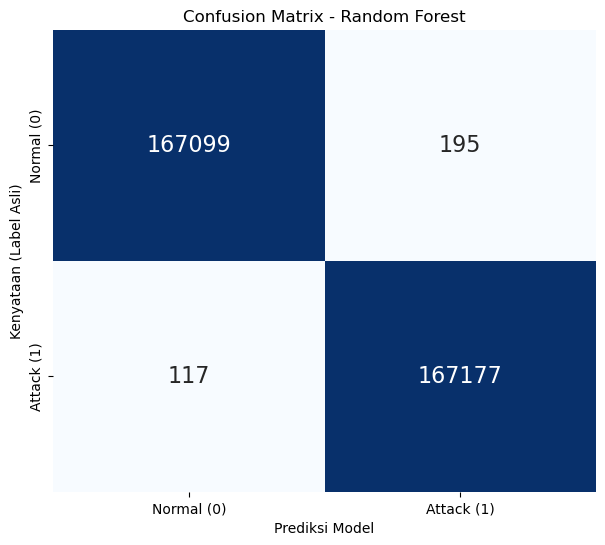

In [23]:
# --- Ambil hasil prediksi dan label asli sebagai list ---
y_true = Y_test.select("BinaryLabel").rdd.flatMap(lambda x: x).collect()
y_pred = rf_pred.select("prediction").rdd.flatMap(lambda x: x).collect()

# --- Fungsi Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]     
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_percent, annot=cm, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes,
                annot_kws={"fontsize":16}, cbar=False) 
    plt.title(title)
    plt.xlabel('Prediksi Model')
    plt.ylabel('Kenyataan (Label Asli)')
    plt.show()

# --- Hitung Metrik ---
rf_accuracy = accuracy_score(y_true, y_pred)
rf_f1 = f1_score(y_true, y_pred)
rf_recall = recall_score(y_true, y_pred)
rf_precision = precision_score(y_true, y_pred)

# --- Laporan dan Visualisasi ---
print('\nRandom Forest Metrics:')
print(f'Accuracy (Akurasi Total): {rf_accuracy:.4f}')
print(f'F1 Score (Keseimbangan): {rf_f1:.4f}')
print(f'Precision (Ketepatan Prediksi Attack): {rf_precision:.4f}')
print(f'Recall (Sensitivitas Deteksi Attack): {rf_recall:.4f}')
print('\nLaporan Klasifikasi Lengkap:\n', classification_report(y_true, y_pred, digits=4))

# --- Plot Confusion Matrix ---
classes = ['Normal (0)', 'Attack (1)']
plot_confusion_matrix(y_true, y_pred, classes, 'Confusion Matrix - Random Forest')
